In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from PIL import Image
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics
import  os
import glob

Found GPU at: /device:GPU:0


In [ ]:
# load mnist data
batch_size = 256
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(batch_size*4).batch(batch_size).repeat()
train_data_iter = iter(train_data)
inputs_shape = [-1, 28, 28, 1]

In [ ]:
class Generator(keras.Model):

    def __init__(self):
        super(Generator, self).__init__()

        self.n_f = 512
        self.n_k = 4

        # input z vector is [None, 100]
        self.dense1 = keras.layers.Dense(3 * 3 * self.n_f)
        self.conv2 = keras.layers.Conv2DTranspose(self.n_f // 2, 3, 2, 'valid')
        self.bn2 = keras.layers.BatchNormalization()
        self.conv3 = keras.layers.Conv2DTranspose(self.n_f // 4, self.n_k, 2, 'same')
        self.bn3 = keras.layers.BatchNormalization()
        self.conv4 = keras.layers.Conv2DTranspose(1, self.n_k, 2, 'same')
        return

    def call(self, inputs, training=None):
        # [b, 100] => [b, 3, 3, 512]
        x = tf.nn.leaky_relu(tf.reshape(self.dense1(inputs), shape=[-1, 3, 3, self.n_f]))
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training))
        x = tf.tanh(self.conv4(x))
        return x


In [ ]:
class Discriminator(keras.Model):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.n_f = 64
        self.n_k = 4

        # input image is [-1, 28, 28, 1]
        self.conv1 = keras.layers.Conv2D(self.n_f, self.n_k, 2, 'same')
        self.conv2 = keras.layers.Conv2D(self.n_f * 2, self.n_k, 2, 'same')
        self.bn2 = keras.layers.BatchNormalization()
        self.conv3 = keras.layers.Conv2D(self.n_f * 4, self.n_k, 2, 'same')
        self.bn3 = keras.layers.BatchNormalization()
        self.flatten4 = keras.layers.Flatten()
        self.dense4 = keras.layers.Dense(1)
        return

    def call(self, inputs, training=None):
        x = tf.nn.leaky_relu(self.conv1(inputs))
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training))
        x = self.dense4(self.flatten4(x))
        return x

In [ ]:
g = Generator()
d = Discriminator()

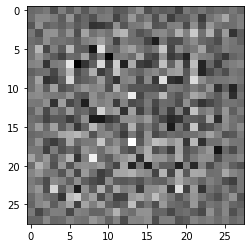

In [ ]:
import imageio
import matplotlib.pyplot as plt

noise = tf.random.normal([1, 100])
generated_image = g(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
decision = d(generated_image)
print (decision)

tf.Tensor([[0.00023654]], shape=(1, 1), dtype=float32)


In [ ]:
z_dim = 50
epochs = 1000
batch_size = 128
learning_rate = 0.0002
is_training = True

In [ ]:
generator = Generator()
generator.build(input_shape=(batch_size, z_dim))
generator.summary()
discriminator = Discriminator()
discriminator.build(input_shape=(batch_size, 28, 28, 1))
discriminator.summary()

# prepare optimizer
d_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
g_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)

Model: "generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  235008    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  1179904   
_________________________________________________________________
batch_normalization_4 (Batch multiple                  1024      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr multiple                  524416    
_________________________________________________________________
batch_normalization_5 (Batch multiple                  512       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr multiple                  2049      
Total params: 1,942,913
Trainable params: 1,942,145
Non-trainable params: 768
___________________________________________

In [ ]:
def loss_real(logits):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                  labels=tf.ones_like(logits)))

def loss_fake(logits):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                  labels=tf.zeros_like(logits)))

In [ ]:
def dis_loss(generator, discriminator, input_noise, real_image, is_trainig):
    fake_image = generator(input_noise, is_trainig)
    d_real_logits = discriminator(real_image, is_trainig)
    d_fake_logits = discriminator(fake_image, is_trainig)

    d_loss_real = loss_real(d_real_logits)
    d_loss_fake = loss_fake(d_fake_logits)
    loss = d_loss_real + d_loss_fake
    return loss

In [ ]:
def gen_loss(generator, discriminator, input_noise, is_trainig):
    fake_image = generator(input_noise, is_trainig)
    fake_loss = discriminator(fake_image, is_trainig)
    loss = loss_real(fake_loss)
    return loss

In [ ]:
for epoch in range(epochs):

    batch_x = next(train_data_iter)
    batch_x = tf.reshape(batch_x, shape=inputs_shape)
    batch_x = batch_x * 2.0 - 1.0
    batch_z = tf.random.normal(shape=[batch_size, z_dim])

    with tf.GradientTape() as tape:
        d_loss = dis_loss(generator, discriminator, batch_z, batch_x, is_training)
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    with tf.GradientTape() as tape:
        g_loss = gen_loss(generator, discriminator, batch_z, is_training)
    grads = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))


    if epoch % 100 == 0:

        print(epoch, 'd loss:', float(d_loss), 'g loss:', float(g_loss))

0 d loss: 1.9925601482391357 g loss: 1.3043920993804932
100 d loss: 0.8000475168228149 g loss: 2.75465726852417
200 d loss: 0.7372235059738159 g loss: 2.4975814819335938
300 d loss: 0.5519148707389832 g loss: 2.7739174365997314
400 d loss: 0.4761248826980591 g loss: 2.104170799255371
500 d loss: 0.6185640096664429 g loss: 2.3288896083831787
600 d loss: 0.6658599972724915 g loss: 2.5580506324768066
700 d loss: 0.6784998178482056 g loss: 1.2318670749664307
800 d loss: 0.5423045754432678 g loss: 1.9270118474960327
900 d loss: 0.596870481967926 g loss: 2.523186445236206


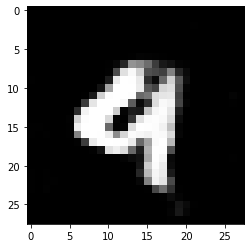

In [ ]:
noise = tf.random.normal([1, 50])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')